In [18]:
# Read a csv file that contains a list of movies on IMDb

import pandas as pd
import numpy as np

fields = ['imdb_title_id', 'year', 'duration', 
          'genre', 'reviews_from_users', 'reviews_from_critics','avg_vote', 'language']

# movies is a data frame
movies = pd.read_csv("IMDb_movies.csv",usecols=fields)

# changing NA values to 0 for reviews_from_users and reviews_from_critics
movies['reviews_from_users'] = movies['reviews_from_users'].fillna(0)
movies['reviews_from_critics'] = movies['reviews_from_critics'].fillna(0)

# new data frame with split value columns 
new_genres = movies["genre"].str.split(", ", n = 2, expand = True)

# making separate genre 1 column from new data frame 
movies["genre_1"]= new_genres[0] 

# making separate genre 2 column from new data frame 
movies["genre_2"]= new_genres[1] 

# making separate genre 3 column from new data frame 
movies["genre_3"]= new_genres[2] 

# dropping old genre column 
movies.drop(columns =["genre"], inplace = True)

#print(movies.dtypes)

years = [2015,2016,2017,2018,2019,2020]
language = ['English']

movies_sample = movies[movies.year.isin(years) & movies.language.isin(language)]

movies_sample2 = movies_sample.drop(['language', 'imdb_title_id'], axis = 1)

movies_sample2 = movies_sample2.filter(['avg_vote', 'genre_1', 'genre_2', 'genre_3', 
                                        'duration', 'reviews_from_users', 
                                        'reviews_from_critics'], axis = 1)

print(movies_sample2.head())

print('Sample_Size:', len(movies_sample2))

#movies_sample2['Successful/Unsuccessful'].describe()    

       avg_vote    genre_1    genre_2   genre_3  duration  reviews_from_users  \
32465       8.8  Animation  Adventure    Comedy        83                 2.0   
42166       6.1     Comedy      Drama      None       113                 4.0   
42384       5.0  Animation  Adventure    Comedy        84                 6.0   
42695       5.5     Horror       None      None        98                46.0   
43366       4.9      Drama     Sci-Fi  Thriller       100               206.0   

       reviews_from_critics  
32465                   0.0  
42166                   4.0  
42384                   1.0  
42695                  34.0  
43366                  74.0  
Sample_Size: 6108


In [19]:
# All 3 genres included in the dummy variables for each genre
G = np.stack([movies_sample2['genre_1'].to_numpy(), 
              movies_sample2['genre_2'].to_numpy(),
              movies_sample2['genre_3'].to_numpy()], 1)

kAllGenres = ["Action", "Adventure", "Animation", "Biography", "Comedy", "Crime",  
              "Drama", "Family", "Fantasy", "History", "Horror", "Musical", "Music", 
              "Mystery", "News", "Reality-TV", "Romance", "Sci-Fi", "Sport", "Thriller", "War", "Western",]
genreFeatures = np.zeros((len(movies_sample2), len(kAllGenres)), dtype=np.int64)
for i, genre in enumerate(kAllGenres):
  y, x = np.nonzero(G == genre)
  genreFeatures[y, i] = 1

for i, genre in enumerate(kAllGenres):
    movies_sample2[genre] = genreFeatures[:,i].tolist()
    
movies_sample2 = movies_sample2.drop(['genre_1', 'genre_2', 'genre_3'], axis = 1)
movies_sample2.head()    

,avg_vote,duration,reviews_from_users,reviews_from_critics,Action,Adventure,Animation,Biography,Comedy,Crime,...,Music,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western
32465,8.8,83,2.0,0.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
42166,6.1,113,4.0,4.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
42384,5.0,84,6.0,1.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
42695,5.5,98,46.0,34.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43366,4.9,100,206.0,74.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [20]:
y = movies_sample2['avg_vote'].values
X = movies_sample2.iloc[:, 1:26].values
X[:5]

array([[ 83.,   2.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [113.,   4.,   4.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [ 84.,   6.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [ 98.,  46.,  34.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [100., 206.,  74.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.]])

In [21]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.25, 
                         shuffle=True, random_state=1)

print('Train/Test sizes:', y_train.shape[0], y_test.shape[0])

Train/Test sizes: 4581 1527


In [23]:
# Scale the features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [37]:
import lightgbm as lgb


boost = lgb.LGBMRegressor(n_estimators=100,
                           max_depth=8,
                           random_state=1,
                           learning_rate=0.1)

boost.fit(X_train, y_train)

print("Test Accuracy: %0.4f" % boost.score(X_test, y_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Test Accuracy: 0.3910


In [25]:
from pprint import pprint
pprint(boost.get_params())

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 1,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


In [30]:
from sklearn.model_selection import GridSearchCV


param_grid = [{'max_depth': [6, 7, 8, 9, -1],
               'learning_rate': [0.1, 0.05],
               'num_leaves': [15, 21, 31]}]

gs = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=1),
                  param_grid=param_grid,
                  refit=True,
                  cv=10,
                  n_jobs=None)

grid_results = gs.fit(X_train, y_train)

best_grid = grid_results.best_estimator_

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [39]:
print('Best score: %.4f%%' % (best_grid.score(X_test, y_test)))
print('Best Params:', gs.best_params_)

Best score: 0.4137%
Best Params: {'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 21}


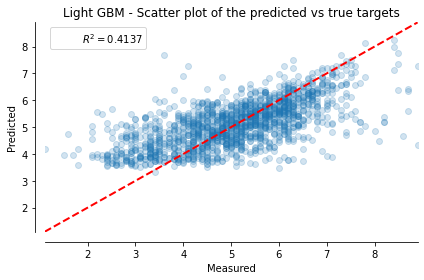

In [33]:
import matplotlib.pyplot as plt

y_pred = best_grid.predict(X_test)
score = (best_grid.score(X_test, y_test))
title = 'Light GBM - Scatter plot of the predicted vs true targets'
ax = plt.axes()

def plot_regression_results(ax, y_true, y_pred, title, scores):
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    ax.set_title(title)
    
plot_regression_results(
        ax, y_test, y_pred,
        title, (r'$R^2={:.4f}$').format(score))

plt.tight_layout()
plt.show()

In [40]:
#### Find feature importances (highest to lowest)

# Get the list of features
list_features = list(movies_sample2.iloc[:, 1:26])

imp = list(best_grid.feature_importances_)

# Pair feature with their importance

feat_imp = [(feature, round(importance, 2)) for feature, 
importance in zip(list_features, imp)]

# Order features by their importance (most important will be at the top of the list)
feat_imp = sorted(feat_imp, key = lambda x: x[1], reverse = True)

# Print out the list
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feat_imp];

Feature: reviews_from_critics Importance: 450
Feature: reviews_from_users   Importance: 400
Feature: duration             Importance: 354
Feature: Horror               Importance: 94
Feature: Action               Importance: 89
Feature: Comedy               Importance: 52
Feature: Sci-Fi               Importance: 52
Feature: Thriller             Importance: 52
Feature: Drama                Importance: 49
Feature: Animation            Importance: 48
Feature: Crime                Importance: 46
Feature: Adventure            Importance: 44
Feature: Musical              Importance: 37
Feature: Biography            Importance: 33
Feature: Music                Importance: 21
Feature: Fantasy              Importance: 20
Feature: Romance              Importance: 19
Feature: Western              Importance: 15
Feature: Mystery              Importance: 12
Feature: Sport                Importance: 9
Feature: History              Importance: 6
Feature: Family               Importance: 5
Feature: W